# Park97 Mismatch library

# Energy landscape analysis

In [1]:
# default modules
import sys
import math
import random
import pickle

In [2]:
# external modules
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# increase figure resolution
plt.rcParams['figure.dpi'] = 100

In [4]:
# custom modules
import analysis_final as analysis
from SliderClass_final import Slider
import graph_final as graph

In [5]:
# working directory
#path = "/home/spark159/../../media/spark159/sw/slide_seq_data(2021.07.14)/"
path = "./"

In [6]:
# basic parameters
tlen = 225 # sliding DNA template length
NCPlen = 147 # nucleosomal DNA length

In [7]:
# load WT 601 sliding data
WT_slider1 = pickle.load(open(path+'Park97_0min'+'.pickle'))['Park97']
WT_slider2 = pickle.load(open(path+'Park97_30min'+'.pickle'))['Park97']

In [8]:
# load mismatch library data
mismatch_sliders1 = pickle.load(open(path+'Park97mmlib_0min_1rep'+'.pickle'))
mismatch_sliders2 = pickle.load(open(path+'Park97mmlib_30min_1rep'+'.pickle'))

In [9]:
# set target ids
common_ids = list(set(mismatch_sliders1.keys()) & set(mismatch_sliders2.keys()))
target_ids = []
for id in common_ids:
    loc, mtype, nts = id.split('-')
    if len(nts) < 1:
        continue
    if len(nts) > 5:
        continue
    target_ids.append(id)
target_ids = sorted(target_ids, cmp=analysis.wid_cmp_len)

In [10]:
# get nucleosome positioning signal
id_psig1, id_psig2 = {}, {}
for id in target_ids:
    psig1 = mismatch_sliders1[id].get_psig()
    psig2 = mismatch_sliders2[id].get_psig()
    id_psig1[id] = psig1
    id_psig2[id] = psig2

In [11]:
# get nucleosome positioning signal change w.r.t WT signal
id_dpsig1, id_dpsig2 = {}, {}
for id in target_ids:
    id_dpsig1[id] = id_psig1[id] - WT_slider1.get_psig()
    id_dpsig2[id] = id_psig2[id] - WT_slider2.get_psig()

In [12]:
# aggregate profile data according to size and position
def aggregate_profile (id_profile):
    size_pos_values = {}
    for id in id_profile:
        profile = id_profile[id]
        loc, mtype, nts = id.split('-')
        size, loc = len(nts), int(loc)

        if size not in size_pos_values:
            size_pos_values[size] = {}
        
        for pos in range(len(profile)):
            value = profile[pos]
            if pos not in size_pos_values[size]:
                size_pos_values[size][pos] = []
            size_pos_values[size][pos].append(value)
            
    return size_pos_values

In [13]:
# aggregate nucleosome positioning change according to size and location of perturbation
size_pos_changes1 = aggregate_profile (id_dpsig1)
size_pos_changes2 = aggregate_profile (id_dpsig2)

In [14]:
# aggregate the values according to the positiong
def aggregate_more (size_pos_values):
    pos_values = {}
    for size in size_pos_values:
        for pos in size_pos_values[size]:
            if pos not in pos_values:
                pos_values[pos] = []
            pos_values[pos] += size_pos_values[size][pos]
    return pos_values

In [15]:
pos_changes1 = aggregate_more (size_pos_changes1)
pos_changes2 = aggregate_more (size_pos_changes2)

In [16]:
def plot_dynamics (pos_values, control_sig):
    fig = plt.figure()
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax2.plot(control_sig, 'k--')
    
    X, Y = [], []
    for pos, values in pos_values.items():
        X += [pos]*len(values)
        Y += list(np.abs(values))        
            
    ax1.scatter(X, Y, c=Y, s=2, cmap='hot_r', alpha=0.25)

    ax2.set_ylabel("WT probability")
    ax1.set_ylabel("Probability change")
    ax2.set_xlabel("Position (bp)")
    plt.title("Signal variation by position")
    plt.tight_layout()
    plt.show()
    plt.close()

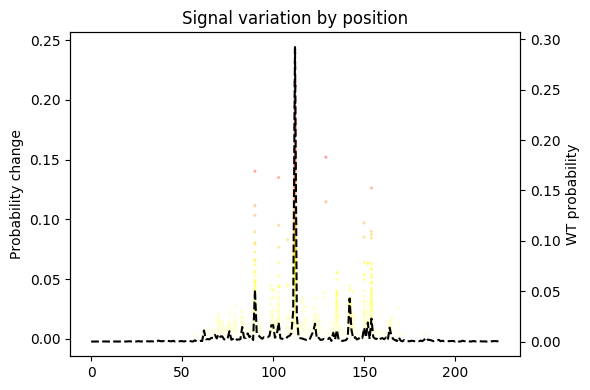

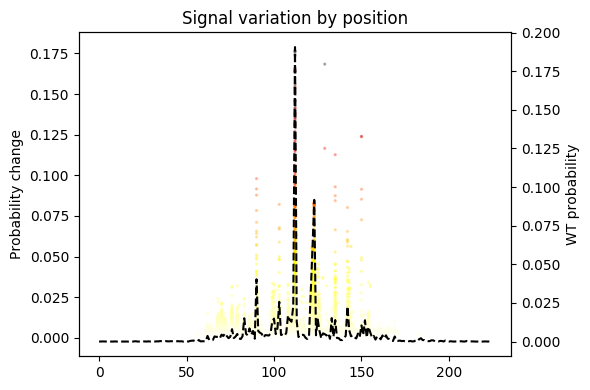

In [17]:
plot_dynamics (pos_changes1, WT_slider1.get_psig())
plot_dynamics (pos_changes2, WT_slider2.get_psig())

In [18]:
# find data variance for each position
pos_var1 = {pos:np.var(changes) for pos, changes in pos_changes1.items()}
pos_var2 = {pos:np.var(changes) for pos, changes in pos_changes2.items()}

In [19]:
# plot the data variance for each position
def plot_var (pos_var, control_sig):
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(control_sig, 'k--')
    ax2 = ax1.twinx()
    X, Y = [], []
    for pos, var in pos_var.items():
        X.append(pos)
        Y.append(var)
    ax2.plot(X, Y)
    ax1.set_ylabel("WT probability")
    ax2.set_ylabel("Variance")
    ax1.set_xlabel("Position (bp)")
    plt.title("Signal variance by position")
    plt.tight_layout()
    plt.show()
    plt.close()    

Before sliding


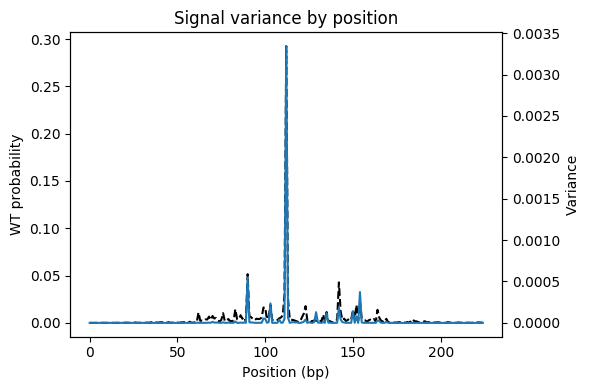

After sliding


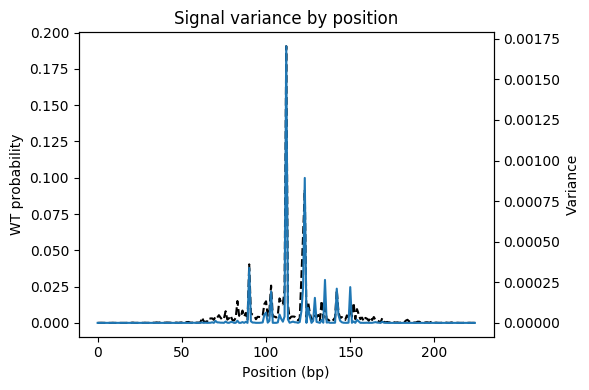

In [20]:
print "Before sliding"
plot_var (pos_var1, WT_slider1.get_psig())
print "After sliding"
plot_var (pos_var2, WT_slider2.get_psig())

In [21]:
# find the positions with the largest dynamic range of data
dynamic_pos_list1 = analysis.dict_sort(pos_var1, reverse=True)[0:1]
dynamic_pos_list2 = analysis.dict_sort(pos_var2, reverse=True)[0:3]

In [22]:
# aggregate data according to perturbation size and position in SHL coordinate
def aggregate_values_inSHL (id_profile, dyads=[]):
    if len(dyads) <= 0:
        dyads = range(NCPlen/2, tlen-NCPlen/2)
    
    dyad_size_shl_values = {}
    for id in id_profile:
        loc, mtype, nts = id.split('-')
        size, loc = len(nts), int(loc)

        for dyad in dyads:
            value = id_profile[id][dyad]
            
            st = loc - dyad
            ed = loc - dyad + size
            if ed - st <= 0:
                continue
                
            if dyad not in dyad_size_shl_values:
                dyad_size_shl_values[dyad] = {}
            if size not in dyad_size_shl_values[dyad]:
                dyad_size_shl_values[dyad][size] = {}
                
            for shl in range(st, ed):
                if shl not in dyad_size_shl_values[dyad][size]:
                    dyad_size_shl_values[dyad][size][shl] = []
                dyad_size_shl_values[dyad][size][shl].append(value)
                
    return dyad_size_shl_values

In [23]:
# get energy landscape profile1 (slow)
fname = path+'Park97mmlib_dyad_size_shl_values1'+'.pickle'
try:
    dyad_size_shl_values1 = pickle.load(open(fname))
except:
    id_dep1 = {}
    for id in target_ids:
        dep1 = mismatch_sliders1[id].energy_profile() - WT_slider1.energy_profile()
        id_dep1[id] = dep1
    dyad_size_shl_values1 = aggregate_values_inSHL (id_dep1, dyads=dynamic_pos_list1)
    pickle.dump(dyad_size_shl_values1, open(fname, 'wb'))

In [24]:
# get energy landscape profile2 (slow)
fname = path+'Park97mmlib_dyad_size_shl_values2'+'.pickle'
try:
    dyad_size_shl_values2 = pickle.load(open(fname))
except:
    id_dep2 = {}
    for id in target_ids:
        dep2 = mismatch_sliders2[id].energy_profile() - WT_slider2.energy_profile()
        id_dep2[id] = dep2
    dyad_size_shl_values2 = aggregate_values_inSHL (id_dep2, dyads=dynamic_pos_list2)
    pickle.dump(dyad_size_shl_values2, open(fname, 'wb'))

In [25]:
# plot nucleosome positioning energy landscape in SHL coordinate
def plot_energy_landscape (dyad_size_shl_values, 
                           dyads=[], 
                           cmap='jet',
                           note=''):
    
    cmap = cm.get_cmap(cmap)
    
    if len(dyads) <= 0:
        dyads = sorted(dyad_size_shl_values.keys())
    
    for dyad in dyads:
        size_shl_values = dyad_size_shl_values[dyad]
        color_list = np.linspace(0, 1, num=len(size_shl_values))
        
        fig = plt.figure(figsize=(1.9, 1.3))
        for i in range(len(size_shl_values)):
            size = sorted(size_shl_values.keys())[i]
            shl_values = size_shl_values[size]
            X, Y = [], []
            for shl in sorted(shl_values):
                X.append(shl)
                Y.append(np.mean(shl_values[shl]))
            #p = plt.plot(X, Y, '.', markersize=2, color=cmap(color_list[i]), label=str(size) + 'bp')
            p = plt.plot(X, Y, '.', markersize=2, label=str(size) + 'bp')
            plt.plot(X, Y, '-', alpha=0.6, color=p[0].get_color())
            
        plt.axvline(x=0, linestyle='--', color='k')
        plt.axhline(y=0, linestyle='--', color='k')
        xticks = [-60, -40, -20, 0, 20, 40, 60]
        for tick in xticks:
            plt.axvline(x=tick, linestyle = '--', linewidth=1, color='k', alpha=0.25)
        plt.xticks(xticks, [str(tick) for tick in xticks], fontsize=6)
        plt.yticks(fontsize=5)
        #plt.title("NCP at position %d" % (dyad), fontsize=10)
        plt.xlim([-80, 80])
        plt.xlabel("SHL coordinate", fontsize=7)
        plt.ylabel("$\Delta$ E", fontsize=7)
        
        #leg = plt.legend()
        #for lh in leg.legendHandles:
        #    lh._legmarker.set_markersize(10)
        
        #plt.tight_layout()
        plt.savefig('_'.join(['Eland',str(dyad),note]) + '.svg', format='svg', bbox_inches='tight')
        plt.show()
        plt.close()

Before sliding


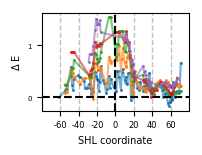

In [26]:
print "Before sliding"
plot_energy_landscape (dyad_size_shl_values1, note='before')

After sliding


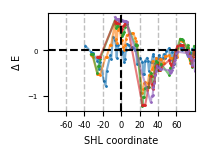

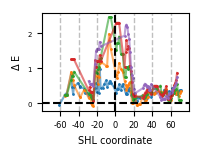

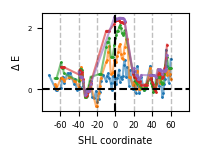

In [27]:
print "After sliding"
plot_energy_landscape (dyad_size_shl_values2, note='after')